### This notebook aims to analyse the NEMO forcing files (boundary conditions and surface forcings) and how WCVI model results conforms to the forcing physics

In [19]:
import numpy as np
import netCDF4 as nc
import xarray as xr
from scipy.interpolate import griddata, interp1d
from salishsea_tools import nc_tools,viz_tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
fname = '/home/ssahu/saurav/JP_BC/cat_42_days_T.nc';

gridT = xr.open_dataset(fname);


In [3]:
gridT.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, deptht: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * deptht             (deptht) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.283 -142.256 -142.228 -142.2 ...
    nav_lat            (y, x) float32 45.0491 45.0479 45.0467 45.0456 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    votemper           (time_counter, deptht, y, x) float64 0.0 8.881 8.905 ...
    vosaline           (time_counter, deptht, y, x) float64 0.0 33.14 33.13 ...
    sosstsst           (time_counter, y, x) float64 0.0 8.881 8.905 8.925 ...
    sosaline           (

In [4]:
#### Load JP's mask

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc');

tmask_JP = mask.variables['tmask'][0,:,55:400,446:701];
umask_JP = mask.variables['umask'][0,:,55:400,446:701];
vmask_JP = mask.variables['vmask'][0,:,55:400,446:701];

print(tmask_JP.shape, umask_JP.shape, vmask_JP.shape)

(50, 345, 255) (50, 345, 255) (50, 345, 255)


In [5]:
#### Slice out our domain of WCVI from JP and mask it at the same time saying the zero values as NAN

votemper_JP = np.array(gridT['votemper'][:,:,55:400,446:701]);
for i in np.arange(votemper_JP.shape[0]):
    votemper_JP[i,...] = np.ma.masked_array(votemper_JP[i,...], mask = tmask_JP[...]);
votemper_JP[votemper_JP == 0] =['Nan'];

vosaline_JP = np.array(gridT['vosaline'][:,:,55:400,446:701]);
for i in np.arange(vosaline_JP.shape[0]):
    vosaline_JP[i,...] = np.ma.masked_array(vosaline_JP[i,...], mask = tmask_JP[...]);
vosaline_JP[vosaline_JP == 0] = ['Nan'];

glamt_bc_JP = np.array(gridT['nav_lon'][55:400,446:701]);
gphit_bc_JP = np.array(gridT['nav_lat'][55:400,446:701]);
deptht_JP = np.array(gridT['deptht'][:]);


In [6]:
#### Load the WCVI points

fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...]; 
    
print((glamt_bc_JP[0,0],gphit_bc_JP[0,0]), (glamt_wcvi[0,0], gphit_wcvi[0,0]))

(-129.93523, 45.455914) (-127.00188120221485, 46.113550613066906)


### WE would be analysing after two days of model run (so we take out 4th day of April from JP's)

In [7]:
X = glamt_bc_JP.flatten();

Y = gphit_bc_JP.flatten();

points = (X[:],Y[:]);

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

votemper_wcvi = np.empty((votemper_JP.shape[1], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));
vosaline_wcvi = np.empty((votemper_JP.shape[1], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));


for j in np.arange(votemper_JP.shape[1]):
    votemper_wcvi[j,...] = np.reshape(griddata(points, votemper_JP[3,j,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)
    vosaline_wcvi[j,...] = np.reshape(griddata(points, vosaline_JP[3,j,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)
        
        
    

In [10]:
fname_U = '/home/ssahu/saurav/JP_BC/cat_43_U.nc';
fname_V = '/home/ssahu/saurav/JP_BC/cat_43_V.nc';

gridU = xr.open_dataset(fname_U);
gridV = xr.open_dataset(fname_V);


nav_lon_U = np.array(gridU['nav_lon'][55:400,446:701]);
nav_lat_U = np.array(gridU['nav_lat'][55:400,446:701]);

nav_lon_V = np.array(gridV['nav_lon'][55:400,446:701]);
nav_lat_V = np.array(gridV['nav_lat'][55:400,446:701]); 

U_vel_BC_unfiltered = np.array(gridU['vozocrtx'][:,:,55:400,446:701]);
V_vel_BC_unfiltered = np.array(gridV['vomecrty'][:,:,55:400,446:701]);


# for a in np.arange(U_vel_BC_unfiltered.shape[0]):
#     for i in np.arange(U_vel_BC_unfiltered.shape[1]):
#         for l in np.arange(U_vel_BC_unfiltered.shape[2]):
#             for m in np.arange(U_vel_BC_unfiltered.shape[3]):
#                 if U_vel_BC_unfiltered[a,i,l,m] == 0:
#                     U_vel_BC_unfiltered[a,i,l,m] == [];


# for a in np.arange(V_vel_BC_unfiltered.shape[0]):
#     for i in np.arange(V_vel_BC_unfiltered.shape[1]):
#         for l in np.arange(V_vel_BC_unfiltered.shape[2]):
#             for m in np.arange(V_vel_BC_unfiltered.shape[3]):
#                 if V_vel_BC_unfiltered[a,i,l,m] == 0:
#                     V_vel_BC_unfiltered[a,i,l,m] == [];
                    
                    
# U_vel_BC = np.empty(U_vel_BC_unfiltered.shape);
# V_vel_BC = np.empty(V_vel_BC_unfiltered.shape);
# for idx, val in enumerate(U_vel_BC_unfiltered[:,...]):
#     U_vel_BC[idx-1,...] = U_vel_BC_unfiltered[idx-2,...]*0.25 + U_vel_BC_unfiltered[idx-1,...]*0.5 + \
#                                 U_vel_BC_unfiltered[idx,...]*0.25;
#     V_vel_BC[idx-1,...] = V_vel_BC_unfiltered[idx-2,...]*0.25 + V_vel_BC_unfiltered[idx-1,...]*0.5 + \
#                                 V_vel_BC_unfiltered[idx,...]*0.25;
    
print(U_vel_BC_unfiltered.shape, V_vel_BC_unfiltered.shape)

(43, 50, 345, 255) (43, 50, 345, 255)


In [12]:
for i in np.arange(U_vel_BC_unfiltered.shape[0]):
    U_vel_BC_unfiltered[i,...] = np.ma.masked_array(U_vel_BC_unfiltered[i,...], mask = umask_JP[...])
    V_vel_BC_unfiltered[i,...] = np.ma.masked_array(V_vel_BC_unfiltered[i, ...], mask = vmask_JP[...])

# "Unstagger" the velocity values by interpolating them to the T-grid points
u_vel_BC_tzyx, v_vel_BC_tzyx = viz_tools.unstagger(U_vel_BC_unfiltered, V_vel_BC_unfiltered)

mag_vel_BC = np.sqrt(np.multiply(u_vel_BC_tzyx,u_vel_BC_tzyx), np.multiply(v_vel_BC_tzyx,v_vel_BC_tzyx));
ang_vel_BC = np.degrees(np.arctan2(v_vel_BC_tzyx, u_vel_BC_tzyx));





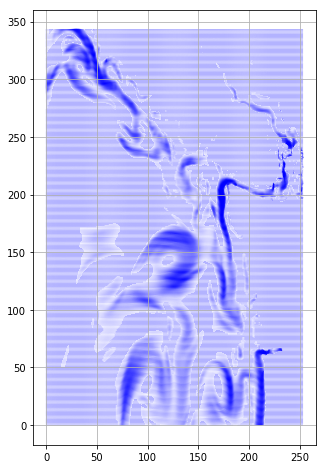

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
quiver = ax.quiver(u_vel_BC_tzyx[0,0,...], v_vel_BC_tzyx[0,0,...], color='blue', pivot='mid')
ax.grid()

plt.show()

In [24]:
import sys
sys.path.insert(0, "/ocean/ssahu/CANYONS/wcvi/grid/")


from grid_alignment import calculate_initial_compass_bearing as cibc

In [25]:
fname_coord_BC = '/home/ssahu/saurav/JP_BC/coordinates.nc'

grid_JP = xr.open_dataset(fname_coord_BC);
glamt = grid_JP.variables['glamt'][55:400,446:701]; gphit = grid_JP.variables['gphit'][55:400,446:701];
glamu = grid_JP.variables['glamu'][55:400,446:701]; gphiu = grid_JP.variables['gphiu'][55:400,446:701];
glamv = grid_JP.variables['glamv'][55:400,446:701]; gphiv = grid_JP.variables['gphiv'][55:400,446:701];


# First point
lonA = glamu[:,0:-1]
latA = gphiu[:,0:-1]
# Second point
lonB = glamu[:,1:]
latB = gphiu[:,1:]


bearing = cibc((latA,lonA),(latB,lonB))
angle_needed = 90 - bearing;

In [27]:


angle_unrotated = np.empty((ang_vel_BC.shape[0],ang_vel_BC.shape[1],ang_vel_BC.shape[2], ang_vel_BC.shape[3]));


for p,q in enumerate(ang_vel_BC[:,...]):
    for i,j in enumerate(ang_vel_BC[p,:,...]):
        angle_unrotated[p,i,...] = ang_vel_BC[p,i,...] + angle_needed[1:,:];
                                
                                
u_unrotated = mag_vel_BC*np.cos(np.radians(angle_unrotated));
v_unrotated = mag_vel_BC*np.sin(np.radians(angle_unrotated));

                                




In [29]:


fname_coord_WCVI = '/home/ssahu/saurav/JP_BC/coordinates_wcvi.nc';

with nc.Dataset(fname_coord_WCVI, 'r') as grid_WCVI:
    glamt_wcvi = grid_WCVI.variables['glamt'][0,:]; gphit_wcvi = grid_WCVI.variables['gphit'][0,:];
    glamu_wcvi = grid_WCVI.variables['glamu'][0,:]; gphiu_wcvi = grid_WCVI.variables['gphiu'][0,:];
    glamv_wcvi = grid_WCVI.variables['glamv'][0,:]; gphiv_wcvi = grid_WCVI.variables['gphiv'][0,:];
    
    
# First point
lonA_wcvi = glamu_wcvi[:,0:-1]
latA_wcvi = gphiu_wcvi[:,0:-1]
# Second point
lonB_wcvi = glamu_wcvi[:,1:]
latB_wcvi = gphiu_wcvi[:,1:]


bearing_wcvi = cibc((latA_wcvi,lonA_wcvi),(latB_wcvi,lonB_wcvi));
angle_needed_wcvi = 90 - bearing_wcvi;



In [32]:
# glamt_cut_JP = glamt[1:,1:]; gphit_cut_JP = gphit[1:,1:];

# X = np.array(glamt_cut_JP).flatten(); Y = np.array(gphit_cut_JP).flatten();

# points = (X[:],Y[:]);

# xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

# u_unrotated_wcvi_t = np.empty((u_unrotated.shape[0],u_unrotated.shape[1],glamt_wcvi.shape[0], glamt_wcvi.shape[1]));
# v_unrotated_wcvi_t = np.empty((v_unrotated.shape[0],v_unrotated.shape[1],glamt_wcvi.shape[0], glamt_wcvi.shape[1]));

# for p,q in enumerate(u_unrotated[:,...]):
#     for i,j in enumerate(v_unrotated[p,:,...]):
#         u_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, u_unrotated[p,i,:,...].flatten(), \
#                                                  xi, method= 'linear'), glamt_wcvi.shape)
#         v_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, v_unrotated[p,i,...].flatten(), \
#                                                  xi, method= 'linear'), glamt_wcvi.shape)

# np.save('u_unrotated_wcvi_t_3D', u_unrotated_wcvi_t);
# np.save('v_unrotated_wcvi_t_3D', v_unrotated_wcvi_t);

In [31]:
u_unrotated_wcvi_t = np.load('/ocean/ssahu/CANYONS/wcvi/grid/u_unrotated_wcvi_t_3D.npy'); 

v_unrotated_wcvi_t = np.load('/ocean/ssahu/CANYONS/wcvi/grid/v_unrotated_wcvi_t_3D.npy');

In [33]:
mag_vel_at_wcvi = np.sqrt(np.multiply(u_unrotated_wcvi_t,u_unrotated_wcvi_t), \
                          np.multiply(v_unrotated_wcvi_t,v_unrotated_wcvi_t));
ang_vel_at_wcvi = np.degrees(np.arctan2(v_unrotated_wcvi_t, u_unrotated_wcvi_t));

angle_unrotated_wcvi = ang_vel_at_wcvi[...,:,1:] - angle_needed_wcvi;

u_unrotated_rotated_to_wcvi = mag_vel_at_wcvi[...,:,1:]*(np.cos(np.radians(angle_unrotated_wcvi[...])));
v_unrotated_rotated_to_wcvi = mag_vel_at_wcvi[...,:,1:]*(np.sin(np.radians(angle_unrotated_wcvi[...])));



In [34]:
def stagger(ugrid, vgrid):
    u = np.add(ugrid[...,:-1], ugrid[...,1:]) / 2;
    v = np.add(vgrid[...,:-1, :], vgrid[...,1:, :]) / 2;
    return u[...,:, :], v[...,:, :]

In [35]:
u_rotated_WCVI, v_rotated_WCVI = stagger(u_unrotated_rotated_to_wcvi, v_unrotated_rotated_to_wcvi)

In [42]:
u_rotated_WCVI.shape, v_rotated_WCVI.shape

((43, 50, 100, 68), (43, 50, 99, 69))

In [43]:
U_filled_WCVI = np.empty((43,50,100,70));
U_filled_WCVI[:,:,:,:-2] = u_rotated_WCVI;
U_filled_WCVI[:,:,:,-2] = U_filled_WCVI[:,:,:,-3]
U_filled_WCVI[:,:,:,-1] = U_filled_WCVI[:,:,:,-3]



V_filled_WCVI = np.empty((43,50,100,70))
V_filled_WCVI[:,:,:-1,:-1] = v_rotated_WCVI;
V_filled_WCVI[:,:,-1,:] = V_filled_WCVI[:,:,-2,:]
V_filled_WCVI[:,:,:,-1] = V_filled_WCVI[:,:,:,-2]



#### This time it should be wise to refit the data to WCVI shape (100,70) by another horizontal interpolation which we wil do now but before we simply made the last column equal to the second last one; so this should be kept in mind while making the boundary conditions the next time or interpolate to a bigger grid and cut it off (I mean make two coo-ordinates.nc wcvi ie one one dimension bigger in each dimension)... may be taken care of when we do FRS with 10 grid points

In [41]:
deptht_JP

array([  4.94025379e-01,   1.54137540e+00,   2.64566851e+00,
         3.81949472e+00,   5.07822371e+00,   6.44061422e+00,
         7.92956018e+00,   9.57299709e+00,   1.14050026e+01,
         1.34671383e+01,   1.58100729e+01,   1.84955597e+01,
         2.15988159e+01,   2.52114086e+01,   2.94447289e+01,
         3.44341545e+01,   4.03440514e+01,   4.73736877e+01,
         5.57642899e+01,   6.58072739e+01,   7.78538513e+01,
         9.23260727e+01,   1.09729279e+02,   1.30665985e+02,
         1.55850723e+02,   1.86125565e+02,   2.22475174e+02,
         2.66040253e+02,   3.18127441e+02,   3.80213013e+02,
         4.53937744e+02,   5.41088928e+02,   6.43566833e+02,
         7.63333069e+02,   9.02339294e+02,   1.06243970e+03,
         1.24529114e+03,   1.45225098e+03,   1.68428442e+03,
         1.94189343e+03,   2.22507788e+03,   2.53333618e+03,
         2.86570264e+03,   3.22082031e+03,   3.59703198e+03,
         3.99248389e+03,   4.40522412e+03,   4.83329053e+03,
         5.27478418e+03,

In [39]:
mask_WCVI = nc.Dataset('/ocean/ssahu/CANYONS/Results/NEMO_trial_viscosity/viscosity_225_30_day_run/mesh_mask.nc')

depth_WCVI = mask_WCVI.variables['nav_lev'][:]

In [40]:
depth_WCVI

array([   14.75075722,    24.42877769,    34.46412659,    45.19285583,
          57.26233673,    71.90678406,    91.43279266,   119.99002075,
         164.52903748,   235.26014709,   344.00537109,   499.3053894 ,
         701.16015625,   941.02905273,  1207.08996582,  1489.1328125 ,
        1780.20678711,  2076.16235352,  2374.69287109,  2674.56420898,
        2975.12866211,  3276.05078125,  3577.15649414,  3878.35668945,
        4179.60546875,  4480.87939453,  4782.16601562], dtype=float32)

In [51]:
U_function = interp1d(deptht_JP, U_filled_WCVI,axis=1,\
                              bounds_error=False, fill_value='extrapolate');
V_function = interp1d(deptht_JP, V_filled_WCVI, axis=1,\
                              bounds_error=False, fill_value='extrapolate');



U_WCVI_depth = np.empty((U_filled_WCVI.shape[0], depth_WCVI.shape[0], \
                               U_filled_WCVI.shape[2], U_filled_WCVI.shape[3]));
V_WCVI_depth = np.empty((U_filled_WCVI.shape[0], depth_WCVI.shape[0], \
                               U_filled_WCVI.shape[2], U_filled_WCVI.shape[3]));


for indx in np.arange(depth_WCVI.shape[0]):
    U_WCVI_depth[:,indx,...]        = U_function(depth_WCVI[indx]);
    V_WCVI_depth[:,indx,...]        = V_function(depth_WCVI[indx]);

    
print(U_WCVI_depth.shape, V_WCVI_depth.shape)

(43, 27, 100, 70) (43, 27, 100, 70)


In [57]:
bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'

/home/ssahu/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))


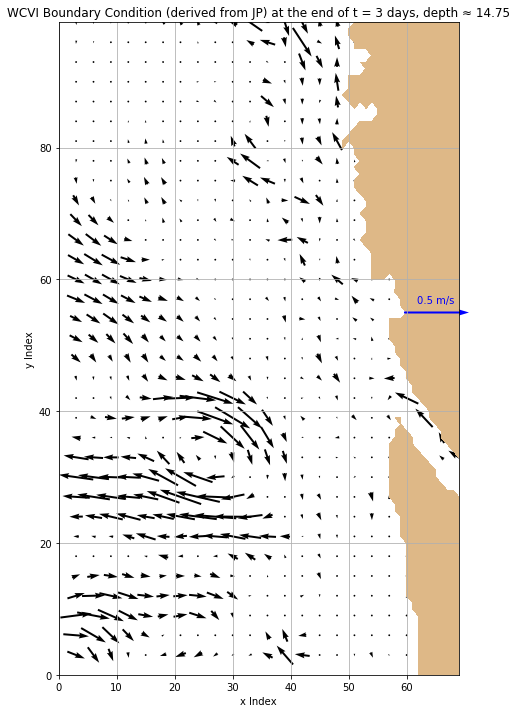

In [70]:
# Define the slice to plot
t, zlevel = 3 , 0
y_slice = np.arange(0, 100)
x_slice = np.arange(0, 70)
# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(U_WCVI_depth[t, zlevel, :, :], 0)
vgrid_tzyx = np.ma.masked_values(V_WCVI_depth[t, zlevel, :, :], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))


arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]


# Plot the velocity vectors
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)
quiver = ax.quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax, bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
# Axes limits and grid
ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('WCVI Boundary Condition (derived from JP) at the end of t = {0} days, depth \u2248 {d:.2f}'.format(t, d=depth_WCVI[zlevel]))
ax.quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='blue', labelcolor='blue')
plt.show()